In [1]:
import torch
import sys
import os.path as osp
import os
import sys
import numpy as np

sys.path.append("/eos/home-g/gkrzmanc/mlpf_data")
from src.dataset.dataset import SimpleIterDataset
from src.utils.utils import to_filelist
from torch.utils.data import DataLoader
#import dgl  # CPU only version for now
from tqdm import tqdm
from torch_scatter import scatter_sum
import matplotlib.pyplot as plt
import pickle
import numpy as np
import mplhep as hep

hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=13)

In [2]:
# This block is the same as 1_dataset.ipynb

dataset = "/eos/home-g/gkrzmanc/dataset_1408_CLIC_more_particles_DS.root"
#dataset = "/eos/user/g/gkrzmanc/ClicDet_v1_25_07_2023_full.root"

class Args:
    def __init__(self):
        self.data_train = [dataset]
        self.data_val = [dataset]
        #self.data_train = files_train
        self.data_config = '/eos/home-g/gkrzmanc/mlpf_data/config_files/config_2_newlinks.yaml'
        self.extra_selection = None
        self.train_val_split = 0.8
        self.data_fraction = 1
        self.file_fraction = 1
        self.fetch_by_files = False
        self.fetch_step = 0.01
        self.steps_per_epoch = None
        self.in_memory = False
        self.local_rank = None
        self.copy_inputs = False
        self.no_remake_weights = False
        self.batch_size = 10
        self.num_workers = 0
        self.demo = False
        self.laplace = False
        self.diffs = False
        self.class_edges = False


args = Args()
train_range = (0, args.train_val_split)
train_file_dict, train_files = to_filelist(args, 'train')
train_data = SimpleIterDataset(train_file_dict, args.data_config, for_training=True,
                               extra_selection=args.extra_selection,
                               remake_weights=True,
                               load_range_and_fraction=(train_range, args.data_fraction),
                               file_fraction=args.file_fraction,
                               fetch_by_files=args.fetch_by_files,
                               fetch_step=args.fetch_step,
                               infinity_mode=False,
                               in_memory=args.in_memory,
                               async_load=False,
                               name='train')

In [3]:
iterator = iter(train_data)
g, gt = next(iterator)
g
g.ndata['particle_number'].unique()
gt
from src.dataset.functions_graph import graph_batch_func

train_loader = DataLoader(train_data, batch_size=1, drop_last=True, pin_memory=True,
                          num_workers=min(args.num_workers, int(len(train_files) * args.file_fraction)),
                          collate_fn=graph_batch_func,
                          persistent_workers=args.num_workers > 0 and args.steps_per_epoch is not None)
iterator = iter(train_loader)


=== Restarting DataIter train, seed=None ===
=== Restarting DataIter train, seed=None ===


In [4]:
g, y = next(iterator)
y.shape
y

tensor([[-3.5594e-02,  9.9030e-01, -1.3432e-01,  3.2605e+01,  3.2591e+01,
          9.3828e-01,  2.2120e+03],
        [-7.3525e-01, -6.7654e-01, -4.1376e-02,  1.9343e+01,  1.9337e+01,
          4.9759e-01,  1.3000e+02],
        [-2.1085e-01,  1.8960e-01, -9.5895e-01,  2.5916e+01,  2.5911e+01,
          4.9768e-01,  1.3000e+02],
        [ 2.6165e-01,  6.8996e-01,  6.7491e-01,  7.0510e+00,  7.0510e+00,
         -8.3870e-04, -2.2120e+03],
        [-3.6641e-02, -5.5886e-02, -9.9776e-01,  8.3010e-01,  6.6442e-01,
          4.9761e-01,  1.3000e+02],
        [ 6.9424e-01, -5.7403e-01,  4.3419e-01,  3.9767e+00,  3.9743e+00,
          1.3956e-01,  2.1100e+02]])

In [5]:
ht = g.ndata["hit_type"]
ht[ht[:, 2]==1]

tensor([[0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        ...,
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0]])

In [6]:
#print(g.ndata["e_hits"].flatten())
#print(g.ndata["h"][:, 7])
hit_energies = g.ndata["e_hits"].flatten()
part_idx = g.ndata["particle_number"]
energy_from_showers = scatter_sum(hit_energies, part_idx.long(), dim=0)[1:]
y_energy = y[:, 3]
#print(y_energy)

In [7]:
fracs1 = energy_from_showers/y_energy
print(fracs1)

tensor([0.5532, 0.8155, 0.5656, 0.2467, 0.3413, 1.1651])


In [8]:
low_frac_particles = np.where(fracs1 < 0.05)[0] + 1
print(low_frac_particles)
low_frac_part_idx = []
for i in range(len(part_idx)):
    #print(part_idx[i])
    if part_idx[i].item() in low_frac_particles:
        low_frac_part_idx.append(i)
print(low_frac_part_idx)

[]
[]


In [9]:
y_energy
type(part_idx)
print(low_frac_part_idx)

[]


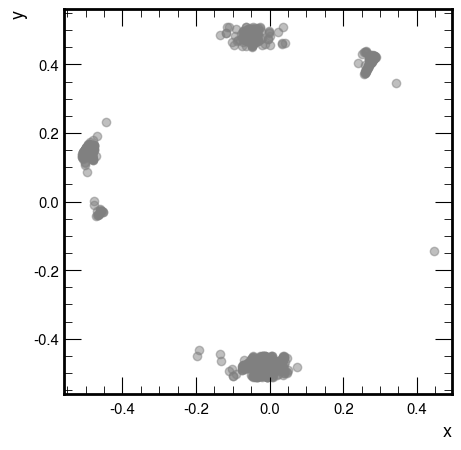

In [10]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(g.ndata["h"][:, 0], g.ndata["h"][:, 1], alpha=0.5, color="gray")
ax.scatter(g.ndata["h"][low_frac_part_idx, 0], g.ndata["h"][low_frac_part_idx, 1], alpha=0.5, c=part_idx[low_frac_part_idx].tolist())
ax.set_xlabel("x")
ax.set_ylabel("y")
#ax.scatter(g.ndata["theta_hits"], g.ndata["phi_hits"], alpha=0.5, color="gray")
#ax.scatter(g.ndata["theta_hits"][low_frac_part_idx], g.ndata["phi_hits"][low_frac_part_idx], alpha=0.5, c=part_idx[low_frac_part_idx].tolist())
fig.show()
fig.savefig("/eos/home-g/gkrzmanc/summ_results/event_example_particle_FILTERED_low_energy_frac11.pdf")

In [11]:
g.ndata["h"][part_idx == 4]

tensor([[0.2574, 0.3723, 0.1731,  ..., 0.0000, 0.0058, 0.0000],
        [0.2582, 0.3737, 0.1731,  ..., 0.0000, 0.0052, 0.0000],
        [0.2589, 0.3750, 0.1731,  ..., 0.0000, 0.0059, 0.0000],
        ...,
        [0.2589, 0.3995, 0.1868,  ..., 0.0000, 0.0088, 0.0000],
        [0.2400, 0.4034, 0.1945,  ..., 0.0000, 0.0099, 0.0000],
        [0.2517, 0.4299, 0.1823,  ..., 0.0000, 0.0082, 0.0000]])

In [12]:
y_energy

tensor([32.6046, 19.3432, 25.9161,  7.0510,  0.8301,  3.9767])

In [13]:
y_pid = y[:, -1].to(torch.long)
y_pid

tensor([ 2212,   130,   130, -2212,   130,   211])

In [14]:
from torch_scatter import scatter_sum
def get_ratios(g, y, corr_w_mass=False, return_pid_dict=False):
    part_idx = g.ndata["particle_number"]
    true_idx = np.arange(len(part_idx))
    part_idx = part_idx[true_idx]
    hit_types = g.ndata["hit_type"][true_idx]
    hit_idx = torch.where((hit_types[:, 2] == 1) | (hit_types[:, 3] == 1))[0]
    track_idx = torch.where((hit_types[:, 0] == 1) | (hit_types[:, 1] == 1))[0]
    hit_energies = g.ndata["e_hits"].flatten()#[true_idx]  #[hit_idx]
    where_e_zero = hit_energies == 0
    hit_momenta = g.ndata["p_hits"].flatten()[true_idx]#[track_idx]
    energy_from_showers = scatter_sum(hit_energies, part_idx.long(), dim=0)
    y_energy = y[:, 3]
    y_energy = y[:, 3]
    y_pid = y[:, -1].to(torch.long)
    energy_from_showers = energy_from_showers[1:]
    assert len(energy_from_showers) > 0
    if return_pid_dict:
        pids = y_pid.unique().long()
        pid_dict = {int(pid): (energy_from_showers[y_pid == pid] / y_energy[y_pid == pid]).tolist() for pid in pids}
        pid_dict["ALL"] = (energy_from_showers / y_energy).tolist()
        return pid_dict
    return (energy_from_showers / y_energy).tolist()


In [15]:
all_ratios = {}
num_particles = []

def upd_dict(d, small_dict):
    for k in small_dict:
        if k not in d:
            d[k] = []
        d[k] += small_dict[k]
    return d

for i in tqdm(range(100)):
    g, y = next(iterator)
    num_part = y.shape[0]
    num_particles.append(num_part)
    ratios = get_ratios(g, y, corr_w_mass=True, return_pid_dict=True)
    all_ratios = upd_dict(all_ratios, ratios)
    #TODOs tmrw: check particle number dist., how many are we throwing away



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.11it/s]


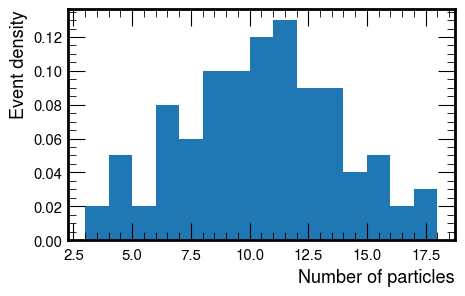

In [16]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.set_xlabel("Number of particles")
ax.hist(num_particles, bins=15, density=True)
ax.set_ylabel("Event density")
fig.show()


In [17]:
for key in all_ratios:
    print(key, len([x for x in all_ratios[key] if x <= 0.05])/len(all_ratios[key]))

-2212 0.0
-211 0.0
130 0.0
2112 0.0
2212 0.0
ALL 0.0
211 0.0


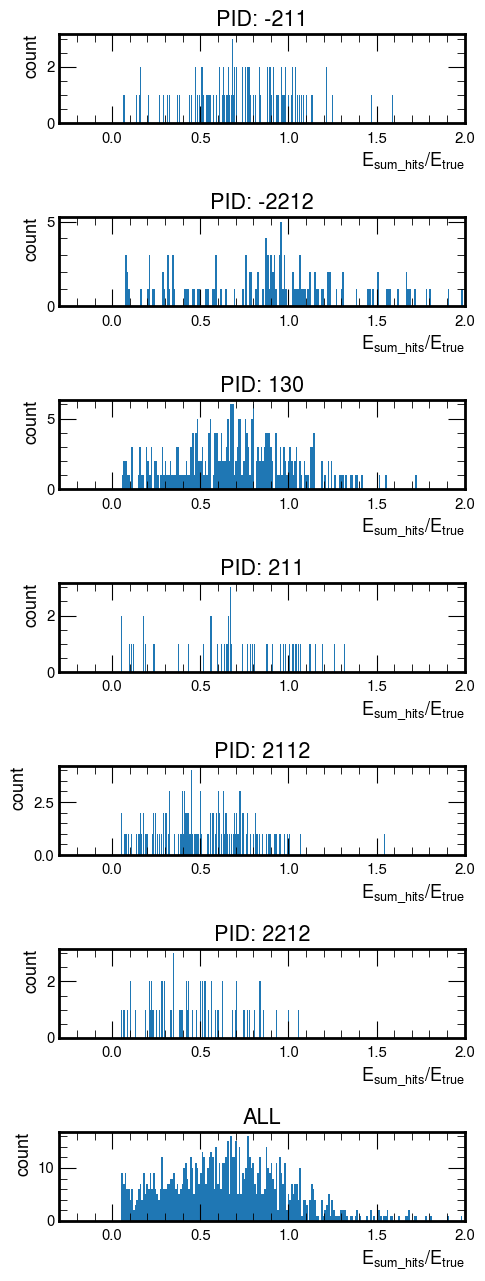

In [19]:
import matplotlib.pyplot as plt
all_ratios = {str(k): v for k, v in all_ratios.items()}
keys = sorted(list(all_ratios.keys()))
fig, ax = plt.subplots(len(keys), figsize=(5, 13))

for i in range(len(keys)):
    ax[i].hist(all_ratios[keys[i]], bins=400)
    ax[i].set_xlim(-0.3, 2)
    ax[i].set_ylabel("count")
    ax[i].set_xlabel(r"$E_{sum\_hits}/E_{true}$")
    #ax[i].set_title(f"{keys[i]} {len(all_ratios[keys[i]])} particles")
    if keys[i] == "ALL":
        ax[i].set_title("ALL")
    else:
        ax[i].set_title(f"PID: {keys[i]}")

fig.tight_layout()

#fig.savefig("/eos/home-g/gkrzmanc/PF_reports/initial_histograms/new_dataset/energy_hist_corr1.pdf")
fig.show()

In [20]:
fig.savefig("/eos/home-g/gkrzmanc/summ_results/1000ev_15_20_part_ds_REMOVED.pdf")